<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Customise/SubclassCustom/Subclassing_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

#### Create a simple model using the model subclassing API

In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Build the model
class MyModel(tf.keras.Model):
    def __init__(self, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.dense_1 = tf.keras.layers.Dense(units=64,
            activation=tf.keras.activations.relu)
        self.dense_2 = tf.keras.layers.Dense(units=10,
            activation=tf.keras.activations.relu)
        self.dense_3 = tf.keras.layers.Dense(units=num_classes,
            activation=tf.keras.activations.softmax)
        self.dropout = tf.keras.layers.Dropout(rate=0.4)

    def call(self, inputs, training=True):
        x1 = self.dense_1(inputs)
        x2 = self.dense_2(inputs)
        concat = tf.keras.layers.Concatenate()([x1, x2])
        concat = self.dropout(concat, training=training)
        return self.dense_3(concat)

# Print the model summary
my_model = MyModel(num_classes=5, name="my_model")
my_model(inputs=tf.random.normal(shape=(1, 10)))
my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  704       
                                                                 
 dense_1 (Dense)             multiple                  110       
                                                                 
 dense_2 (Dense)             multiple                  375       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
Total params: 1189 (4.64 KB)
Trainable params: 1189 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

#### Create custom layers

In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Create a custom layer to accumulate means of output values
class MyLayerMean(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        # Specify trainable weights
        self.b = self.add_weight(shape=(units,),
            initializer=tf.keras.initializers.Zeros())
        self.sum_activation = tf.Variable(
            initial_value=tf.zeros(shape=(units,)),
            trainable=False)
        self.number_call = tf.Variable(initial_value=0,
            trainable=False)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer=tf.keras.initializers.RandomNormal())

    def call(self, inputs):
        activations = tf.linalg.matmul(a=inputs, b=self.w) + self.b
        self.sum_activation.assign_add(delta=tf.math.reduce_sum(
            input_tensor=activations, axis=0))
        self.number_call.assign_add(delta=inputs.shape[0])
        return activations, self.sum_activation \
            / tf.cast(x=self.number_call, dtype=tf.float32)

dense_layer = MyLayerMean(units=3)

# Test the layer
x = tf.ones(shape=(2, 5))
y, activation_means = dense_layer(inputs=x)
print("trainable weights:", len(dense_layer.trainable_weights))
print("non-trainable weights:", len(dense_layer.non_trainable_weights))
print(f"activation_means: {activation_means.numpy()}")
print(f"weights: {dense_layer.weights}")

trainable weights: 2
non-trainable weights: 2
activation_means: [ 0.01885552 -0.07703885 -0.2915517 ]
weights: [<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, <tf.Variable 'my_layer_mean/Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.02358919, -0.01442928, -0.0221293 ],
       [ 0.06809177, -0.09231842, -0.06502789],
       [ 0.01064425,  0.0060349 , -0.04163619],
       [-0.0387267 ,  0.03659106, -0.10442163],
       [ 0.00243539, -0.01291711, -0.05833671]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([ 0.03771103, -0.1540777 , -0.5831034 ], dtype=float32)>, <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2>]


#### Implement the custom layers into a model

In [2]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)

# Build the model using custom layers with the model subclassing API
class MyModel(tf.keras.Model):
    def __init__(self, units_1, units_2, units_3, **kwargs):
        super().__init__(**kwargs)
        # Define layers
        self.layer_1 = MyLayer(units=units_1)
        self.dropout_1 = MyDropout(rate=0.5)
        self.layer_2 = MyLayer(units=units_2)
        self.dropout_2 = MyDropout(rate=0.5)
        self.layer_3 = MyLayer(units=units_3)
        self.softmax = tf.keras.layers.Softmax()

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs=inputs)
        x = tf.nn.relu(features=x)
        x = self.dropout_1(inputs=x)
        x = self.layer_2(inputs=x)
        x = tf.nn.relu(features=x)
        x = self.dropout_2(inputs=x)
        x = self.layer_3(inputs=x)
        return tf.nn.softmax(logits=x)

# Create a custom layer
class MyLayer(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
      super().__init__(**kwargs)
      self.units = units
      self.b = self.add_weight(shape=(units,),
          initializer=tf.keras.initializers.Zeros())

  def build(self, input_shape):
      self.w = self.add_weight(shape=(input_shape[-1], self.units),
          initializer=tf.keras.initializers.RandomNormal())

  def call(self, inputs):
      return tf.linalg.matmul(a=inputs, b=self.w) + self.b

# Create a Dropout layer as a custom layer
class MyDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(x=inputs, rate=self.rate)

# Instantiate a model object
my_model = MyModel(units_1=64, units_2=64, units_3=46, name="my_model")
print(my_model(inputs=tf.random.normal(shape=(1, 10000))))
my_model.summary()

tf.Tensor(
[[0.03964709 0.01326959 0.02763752 0.01076229 0.00946367 0.03262108
  0.01824417 0.00908988 0.06717899 0.0657099  0.01522712 0.01349179
  0.02473041 0.0173228  0.01864109 0.03071251 0.01356732 0.01164669
  0.03300928 0.00993308 0.01679035 0.01374916 0.06827163 0.02038475
  0.00887606 0.01661217 0.01125773 0.0161174  0.02482517 0.01127255
  0.00647558 0.01062837 0.01034763 0.00456736 0.05896313 0.00457546
  0.00695589 0.01401419 0.02193612 0.03387663 0.02122179 0.0189374
  0.02321724 0.03404636 0.02700518 0.01316846]], shape=(1, 46), dtype=float32)
Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_layer (MyLayer)          multiple                  640064    
                                                                 
 my_dropout (MyDropout)      multiple                  0         
                                                                 
 my_layer_1 (MyLayer)

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [ ]:
import tensorflow as tf

x = tf.constant([0, 1, 2, 3], dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.reduce_sum(x**2)
    z = tf.math.sin(y)
    dz_dy, dz_dx = tape.gradient(z, [y, x])

print(dz_dy, "\n", dz_dx)

tf.Tensor(0.13673723, shape=(), dtype=float32) 
 tf.Tensor([0.         0.27347445 0.5469489  0.82042336], shape=(4,), dtype=float32)


In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#### Create synthetic data

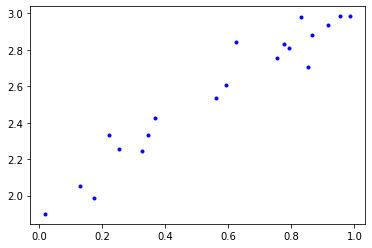

In [ ]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')
plt.show()

#### Define a linear regression model

In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):

    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1, ),
            initializer='random_normal')
        self.b = self.add_weight(shape=(1, ),
            initializer='zeros')

    def call(self, inputs):
        return self.m*inputs+self.b

linear_regression = LinearLayer()
print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[0.12323282 0.07531414 0.11656261 0.00264567 0.11461526 0.10679599
 0.13254023 0.02995865 0.04930686 0.08388655 0.10453741 0.03422887
 0.04383827 0.0795267  0.01734196 0.12852322 0.02318839 0.1116631
 0.04650161 0.10129283], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.13454984], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [ ]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.3086176


#### Train and plot the model

In [ ]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):

    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions, y_train)

    gradients = tape.gradient(loss,
        linear_regression.trainable_variables)

    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])

    print("Step %d, Loss %f" % (i, loss.numpy()))

Step 0, Loss 6.308618
Step 1, Loss 4.728327
Step 2, Loss 3.544499
Step 3, Loss 2.657668
Step 4, Loss 1.993321
Step 5, Loss 1.495641
Step 6, Loss 1.122815
Step 7, Loss 0.843518
Step 8, Loss 0.634286
Step 9, Loss 0.477540
Step 10, Loss 0.360113
Step 11, Loss 0.272140
Step 12, Loss 0.206232
Step 13, Loss 0.156853
Step 14, Loss 0.119856
Step 15, Loss 0.092135
Step 16, Loss 0.071363
Step 17, Loss 0.055797
Step 18, Loss 0.044130
Step 19, Loss 0.035384
Step 20, Loss 0.028827
Step 21, Loss 0.023910
Step 22, Loss 0.020220
Step 23, Loss 0.017451
Step 24, Loss 0.015372


m:1,  trained m:[1.2046332]
b:2,  trained b:[1.813714]


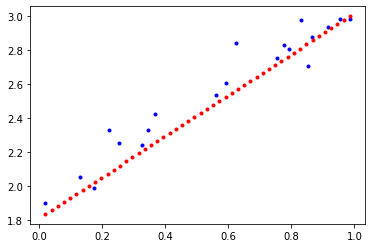

In [ ]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression,
    linear_regression.m*x_linear_regression+linear_regression.b,
    'r.')
plt.show()

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD
import numpy as np

my_model = MyModel()

# def loss(y_hat, y):
#     return tf.reduce_mean(tf.square(y_hat - y))

loss = MeanSquaredError()
optimizer = SGD(learning_rate=0.05, momentum=0.9)

epoch_losses = []

for epoch in range(num_epochs):
    batch_losses = []

    for inputs, outputs in training_datasets:
        with tf.GradientTape() as tape:
            current_loss = loss(my_model(inputs), outputs)
            grads = tape.gradient(current_loss,
                my_model.trainable_variables)

        batch_losses.append(current_loss)
        optimizer.apply_gradients(zip(grads,
                my_model.trainable_variables))

    epoch_losses.append(np.mean(batch_losses))

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [ ]:
# Define the custom layers and model

class MyLayer(Layer):

    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer='random_normal', name='kernel')
        self.b = self.add_weight(shape=(self.units, ),
            initializer='zeros', name='bias')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # Define forwared pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [ ]:
# Instantiate the model object

model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01118078 0.00525199 0.01426291 0.0171649  0.08723421 0.01139885
  0.06960411 0.02470182 0.00222714 0.01687782 0.01972567 0.01846476
  0.00697674 0.00295534 0.00404295 0.00515138 0.00912909 0.00837477
  0.00412501 0.0043536  0.00394924 0.00212455 0.02400699 0.01216442
  0.00101893 0.1369465  0.04031    0.00086793 0.01442129 0.06603812
  0.0169418  0.0387236  0.00194447 0.0075574  0.00940368 0.02568662
  0.05426175 0.00081219 0.00996874 0.00710806 0.01574037 0.00388332
  0.00102361 0.00258901 0.149769   0.00953453]], shape=(1, 46), dtype=float32)
Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_8 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_4 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_9 (MyLaye

#### Load the reuters dataset and define the class_names

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = \
    reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper',
    'housing','money-supply','coffee','sugar','trade','reserves','ship',
    'cotton','carcass','crude','nat-gas','cpi','money-fx','interest','gnp',
    'meal-feed','alum','oilseed','gold','tin','strategic-metal','livestock',
    'retail','ipi','iron-steel','rubber','heat','jobs','lei','bop','zinc',
    'orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value)
    in word_to_index.items()])

557056/550378 [==============================] - 0s 0us/step


In [ ]:
# Print the first data example sentence

text_news = ' '.join([invert_word_index.get(i - 3, '?')
    for i in train_data[0]])
print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k))
        for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [ ]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value,
        model.trainable_variables)

In [ ]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Training loop
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads,
            model.trainable_variables))

        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(
        epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 3.309, Accuracy: 48.497%
Epoch 001: Loss: 1.911, Accuracy: 61.434%
Epoch 002: Loss: 1.820, Accuracy: 65.809%
Epoch 003: Loss: 1.792, Accuracy: 67.836%
Epoch 004: Loss: 1.776, Accuracy: 68.893%
Epoch 005: Loss: 1.751, Accuracy: 69.439%
Epoch 006: Loss: 1.724, Accuracy: 69.684%
Epoch 007: Loss: 1.717, Accuracy: 70.296%
Epoch 008: Loss: 1.721, Accuracy: 70.085%
Epoch 009: Loss: 1.712, Accuracy: 70.574%
Duration :46.495


#### Evaluate the model

In [ ]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)
    # Compute current loss
    epoch_loss_avg(loss_value)
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.815
Test accuracy: 67.275%


#### Plot the learning curves

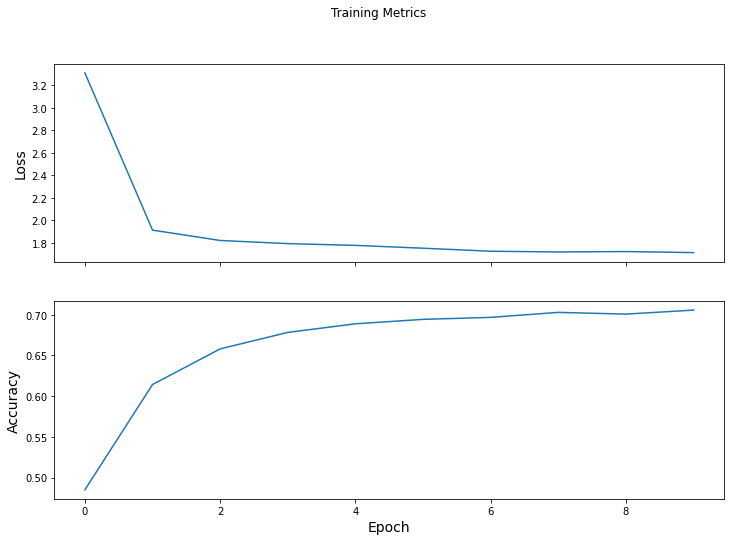

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import SGD

my_model = MyModel()
loss = MeanSquaredError()
optimizer = SGD(learning_rate=0.05, momentum=0.9)

@tf.function
def get_loss_and_grads(inputs, outputs):
    with tf.GradientTape() as tape:
        current_loss = loss(my_model(inputs), outputs)
        grads = tape.gradient(current_loss,
            my_model.trainable_variables)
    return current_loss, grads

for epoch in range(num_epochs):
    for inputs, outputs in training_dataset:
        current_loss, grads = get_loss_and_grads(inputs, outputs)
        optimizer.apply_gradients(zip(grads,
            my_model.trainable_variables))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time

#### Build the model

In [ ]:
# Define the custom layers and model

class MyLayer(Layer):

    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
            initializer='random_normal', name='kernel')
        self.b = self.add_weight(shape=(self.units, ),
            initializer='zeros', name='bias')

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate

    def call(self, inputs):
        # Define forwared pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()

    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

# Initialize a new model

model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01971349 0.0128117  0.01281833 0.01806461 0.02666165 0.01890017
  0.03147139 0.00964301 0.01691275 0.0289935  0.01865787 0.02058025
  0.01223264 0.02273865 0.00546703 0.02286484 0.0150119  0.01376886
  0.00987451 0.02398963 0.02541195 0.04581803 0.01048673 0.03026778
  0.01948599 0.0414695  0.04172915 0.01312426 0.01371575 0.02741901
  0.01029295 0.02534913 0.04003927 0.01897906 0.01478054 0.0186229
  0.01920601 0.01592984 0.02524102 0.0527998  0.0153937  0.015901
  0.03862935 0.03238732 0.01285238 0.01349079]], shape=(1, 46), dtype=float32)
Model: "my_model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_11 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_6 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_12 (MyLayer)

#### Load the reuters dataset and define the class_names

In [ ]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = \
    reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat',
    'copper','housing','money-supply','coffee','sugar','trade',
    'reserves','ship','cotton','carcass','crude','nat-gas','cpi',
    'money-fx','interest','gnp','meal-feed','alum','oilseed','gold',
    'tin','strategic-metal','livestock','retail','ipi','iron-steel',
    'rubber','heat','jobs','lei','bop','zinc','orange','pet-chem',
    'dlr','gas','silver','wpi','hog','lead']

In [ ]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [ ]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value)
    in word_to_index.items()])

In [ ]:
# Print the first data example sentence

text_news = ' '.join([invert_word_index.get(i - 3, '?')
    for i in train_data[0]])
print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [ ]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer

In [ ]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k))
        for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value,
        model.trainable_variables)

#### Train the model

In [ ]:
# Re-run the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Training loop
    for x, y in train_dataset:
        # Optimize the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads,
            model.trainable_variables))

        # Compute current loss
        epoch_loss_avg(loss_value)
        # Compare predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))

    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(
        epoch, epoch_loss_avg.result(), epoch_accuracy.result()))

print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss: 3.318, Accuracy: 47.874%
Epoch 001: Loss: 1.906, Accuracy: 61.701%
Epoch 002: Loss: 1.816, Accuracy: 65.442%
Epoch 003: Loss: 1.771, Accuracy: 67.491%
Epoch 004: Loss: 1.754, Accuracy: 68.470%
Epoch 005: Loss: 1.737, Accuracy: 69.472%
Epoch 006: Loss: 1.730, Accuracy: 69.695%
Epoch 007: Loss: 1.705, Accuracy: 70.196%
Epoch 008: Loss: 1.705, Accuracy: 70.463%
Epoch 009: Loss: 1.706, Accuracy: 70.385%
Duration :29.538


#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

